<a href="https://colab.research.google.com/github/zlkhyr/NllbNusaX/blob/main/NllbClassifier(fine_tuning).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install datasets
!pip install torchinfo

#Library

In [2]:
import torch
import pandas as pd
import torch.nn as nn
from tqdm import tqdm
from torch.optim import AdamW
from google.colab import files
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torch.utils.data import TensorDataset, DataLoader, random_split
# from datasets import load_dataset, concatenate_datasets
from transformers import (
    AutoModelForSeq2SeqLM,
    AutoTokenizer
)

#Load Nllb

In [3]:
model_name = "facebook/nllb-200-distilled-600M"
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/846 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/564 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/4.85M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.3M [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

#Data Preporocessing

In [4]:
train = pd.read_csv('/content/drive/MyDrive/Final_Year/data_train.csv')
val = pd.read_csv('/content/drive/MyDrive/Final_Year/data_val.csv')
test = pd.read_csv('/content/drive/MyDrive/Final_Year/data_test.csv')

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    6000 non-null   object
 1   label   6000 non-null   object
 2   bahasa  6000 non-null   object
dtypes: object(3)
memory usage: 140.8+ KB


In [6]:
label_map = {"negative": 0, "neutral": 1, "positive": 2}
train["label"] = train["label"].map(label_map)
val["label"] = val["label"].map(label_map)
test["label"] = test["label"].map(label_map)

In [7]:
# map_bahasa ={
#   'aceh' : 'ace_Latn',
#   'bali' : 'ban_Latn',
#   'banjar' : 'bjn_Latn',
#   'bugis' : 'bug_Latn',
#   'indonesia' : 'ind_Latn',
#   'inggris' : 'eng_Latn',
#   'jawa' : 'jav_Latn',
#   'minang' : 'min_Latn',
#   'sunda' : 'sun_Latn',

#   'batak toba' : 'ind_Latn',
#   'madura' : 'ind_Latn',
#   'ngaju' : 'ind_Latn'
# }

In [8]:
def preprocess(dataset, shuffle):

  encoding = tokenizer(
      dataset['text'].tolist(),
      padding=True,
      truncation=True,
      max_length=model.config.max_length,
      return_tensors="pt"
  )

  labels = torch.tensor(dataset['label'].tolist(), dtype=torch.long)
  dataset = TensorDataset(encoding['input_ids'], encoding['attention_mask'], labels)
  dataloader = DataLoader(dataset, batch_size=32, shuffle=shuffle)
  return dataloader

In [9]:
train_dataloader = preprocess(train, True)
val_dataloader = preprocess(val, False)

## Preprocessing untuk dokumentasi

In [ ]:
train['label_numerik'] = train['label'].map(label_map)

In [ ]:
train[train.bahasa == 'indonesia'].head(10)

,text,label,bahasa,label_numerik
3500,Nikmati cicilan 0% hingga 12 bulan untuk pemes...,neutral,indonesia,1
3501,Kue-kue yang disajikan bikin saya bernostalgia...,positive,indonesia,2
3502,Ibu pernah bekerja di grab indonesia,neutral,indonesia,1
3503,Paling suka banget makan siang di sini ayam sa...,positive,indonesia,2
3504,Pelayanan bus DAMRI sangat baik,positive,indonesia,2
3505,Mau bikin postingan yang isinya mengedukasi cu...,neutral,indonesia,1
3506,Ratusan rumah di medan terendam banjir,neutral,indonesia,1
3507,"Barangnya lumayan, cuma yang saya heran xiaomi...",negative,indonesia,0
3508,Sulit sekali mempercayai orang yang sudah pern...,negative,indonesia,0
3509,"Lokasi di gombel dengan pemandangan semarang, ...",positive,indonesia,2


In [ ]:
encoding = tokenizer(
    train['text'].tolist(),
    padding=True,
    truncation=True,
    max_length=tokenizer.model_max_length,
    return_tensors="pt"
)

In [ ]:
for k, v in encoding.items():
  print(k,":\n",v)

input_ids :
 tensor([[256047,    909,   2244,  ...,      1,      1,      1],
        [256047,   1335,    407,  ...,      1,      1,      1],
        [256047,  52423,   3732,  ...,      1,      1,      1],
        ...,
        [256047, 171088,  11800,  ...,      1,      1,      1],
        [256047,   7432,   5103,  ...,      1,      1,      1],
        [256047,  23153,     96,  ...,      1,      1,      1]])
attention_mask :
 tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])


In [ ]:
labels = torch.tensor(train['label_numerik'].tolist(), dtype=torch.long)
labels

tensor([1, 2, 1,  ..., 2, 0, 0])

In [ ]:
dataset = TensorDataset(encoding['input_ids'], encoding['attention_mask'], labels)

In [ ]:
dataset.tensors

(tensor([[256047,    909,   2244,  ...,      1,      1,      1],
         [256047,   1335,    407,  ...,      1,      1,      1],
         [256047,  52423,   3732,  ...,      1,      1,      1],
         ...,
         [256047, 171088,  11800,  ...,      1,      1,      1],
         [256047,   7432,   5103,  ...,      1,      1,      1],
         [256047,  23153,     96,  ...,      1,      1,      1]]),
 tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 tensor([1, 2, 1,  ..., 2, 0, 0]))

In [ ]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
for batch in dataloader:
  print(batch[0] ,'\n', batch[1], '\n', batch[2])
  break

tensor([[256047,   3459,  23574,  ...,      1,      1,      1],
        [256047, 131631,   4587,  ...,      1,      1,      1],
        [256047,  29089,  69105,  ...,      1,      1,      1],
        ...,
        [256047,  41989,     13,  ...,      1,      1,      1],
        [256047,  39157,    969,  ...,      1,      1,      1],
        [256047, 197049,   6360,  ...,      1,      1,      1]]) 
 tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]) 
 tensor([0, 1, 0, 0, 1, 0, 2, 0, 1, 0, 0, 2, 2, 2, 2, 2, 0, 1, 0, 2, 0, 0, 0, 2,
        0, 0, 0, 0, 0, 0, 0, 2])


#Pengembangan Model

##Model NllbClassifier

In [10]:
class NllbClassifier(nn.Module):
    def __init__(self, encoder, num_labels=3):
        super().__init__()
        self.encoder = encoder #encoder dari NLLB model
        self.dropout = nn.Dropout(0.2)
        self.classifier = nn.Linear(encoder.config.hidden_size, num_labels)

    def mean_pooling(self, model_output, attention_mask):
        token_embeddings = model_output.last_hidden_state
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

    def forward(self, input_ids, attention_mask):
        #Menghapus spesial token di awal tiap text input (language token)
        input_ids = input_ids[:, 1:]
        attention_mask = attention_mask[:, 1:]

        #Forward pass ke encoder
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)

        # Pooling dengan attention_mask
        pooled_output = self.mean_pooling(outputs, attention_mask)

        # Dropout layer
        pooled_output = self.dropout(pooled_output)

        # Classification layer
        logits = self.classifier(pooled_output)

        return logits

#Model

In [11]:
encoder = model.get_encoder()

In [12]:
encoder

M2M100Encoder(
  (embed_tokens): M2M100ScaledWordEmbedding(256206, 1024, padding_idx=1)
  (embed_positions): M2M100SinusoidalPositionalEmbedding()
  (layers): ModuleList(
    (0-11): 12 x M2M100EncoderLayer(
      (self_attn): M2M100Attention(
        (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (activation_fn): ReLU()
      (fc1): Linear(in_features=1024, out_features=4096, bias=True)
      (fc2): Linear(in_features=4096, out_features=1024, bias=True)
      (final_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    )
  )
  (layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
)

In [13]:
modelFT = NllbClassifier(encoder, num_labels=3)

In [14]:
modelFT

NllbClassifier(
  (encoder): M2M100Encoder(
    (embed_tokens): M2M100ScaledWordEmbedding(256206, 1024, padding_idx=1)
    (embed_positions): M2M100SinusoidalPositionalEmbedding()
    (layers): ModuleList(
      (0-11): 12 x M2M100EncoderLayer(
        (self_attn): M2M100Attention(
          (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (activation_fn): ReLU()
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (final_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      )
    )
    (layer_norm): LayerNorm((1024,), eps=1e-05, e

#Freezing



In [ ]:
for param in modelFT.encoder.embed_tokens.parameters():
  param.requires_grad = False

#Training

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Code running di: {device}")

Code running di: cuda


In [16]:
modelFT.to(device)

NllbClassifier(
  (encoder): M2M100Encoder(
    (embed_tokens): M2M100ScaledWordEmbedding(256206, 1024, padding_idx=1)
    (embed_positions): M2M100SinusoidalPositionalEmbedding()
    (layers): ModuleList(
      (0-11): 12 x M2M100EncoderLayer(
        (self_attn): M2M100Attention(
          (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (activation_fn): ReLU()
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (final_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      )
    )
    (layer_norm): LayerNorm((1024,), eps=1e-05, e

In [17]:
from torchinfo import summary
summary(modelFT)

Layer (type:depth-idx)                                  Param #
NllbClassifier                                          --
├─M2M100Encoder: 1-1                                    --
│    └─M2M100ScaledWordEmbedding: 2-1                   262,354,944
│    └─M2M100SinusoidalPositionalEmbedding: 2-2         --
│    └─ModuleList: 2-3                                  --
│    │    └─M2M100EncoderLayer: 3-1                     12,596,224
│    │    └─M2M100EncoderLayer: 3-2                     12,596,224
│    │    └─M2M100EncoderLayer: 3-3                     12,596,224
│    │    └─M2M100EncoderLayer: 3-4                     12,596,224
│    │    └─M2M100EncoderLayer: 3-5                     12,596,224
│    │    └─M2M100EncoderLayer: 3-6                     12,596,224
│    │    └─M2M100EncoderLayer: 3-7                     12,596,224
│    │    └─M2M100EncoderLayer: 3-8                     12,596,224
│    │    └─M2M100EncoderLayer: 3-9                     12,596,224
│    │    └─M2M100EncoderLaye

In [18]:
optimizer = AdamW([
    {'params': modelFT.encoder.parameters(), 'lr': 1e-5},
    {'params': modelFT.classifier.parameters(), 'lr': 5e-4},
])
loss_fn = nn.CrossEntropyLoss()

In [19]:
# optimizer = AdamW(modelFT.parameters(), lr=1e-5)
# loss_fn = nn.CrossEntropyLoss()

In [20]:
history = {
        'train_loss':[],
        'val_loss':[],
        'train_acc':[],
        'val_acc':[]
    }

In [21]:
epochs = 10
patience = 3
best_val_loss = float('inf')
counter = 0

for epoch in range(epochs):
        modelFT.train()
        total_train_loss = 0
        correct_train = 0
        total_train = 0

        for batch in tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{epochs} [Train]", leave=False):
            input_ids, attention_mask, labels = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            outputs = modelFT(input_ids, attention_mask)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        avg_train_loss = total_train_loss / len(train_dataloader)
        train_accuracy = correct_train / total_train
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_accuracy)

        modelFT.eval()
        total_val_loss = 0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for batch in tqdm(val_dataloader, desc=f"Epoch {epoch + 1}/{epochs} [Validation]", leave=False):
                input_ids, attention_mask, labels = batch
                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)
                labels = labels.to(device)

                outputs = modelFT(input_ids, attention_mask)
                loss = loss_fn(outputs, labels)

                total_val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        avg_val_loss = total_val_loss / len(val_dataloader)
        val_accuracy = correct_val / total_val
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_accuracy)

        print(f"Epoch [{epoch + 1}/{epochs}], Loss:{avg_train_loss:.4f}, Validation Loss:{avg_val_loss:.4f}, Accuracy:{train_accuracy:.2f}, Validation Accuracy:{val_accuracy:.2f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            counter = 0
            torch.save(modelFT.state_dict(), 'best_model.pth')
        else:
            counter += 1
            print(f"Early stopping counter: {counter}/{patience}")
            if counter >= patience:
                print(f"Early stopping triggered at epoch {epoch + 1}")
                break

Epoch [1/10], Loss:0.7878, Validation Loss:0.6808, Accuracy:0.66, Validation Accuracy:0.72


Epoch [2/10], Loss:0.4959, Validation Loss:0.5856, Accuracy:0.81, Validation Accuracy:0.77


Epoch [3/10], Loss:0.3528, Validation Loss:0.5770, Accuracy:0.87, Validation Accuracy:0.78


Epoch [4/10], Loss:0.2565, Validation Loss:0.5993, Accuracy:0.91, Validation Accuracy:0.79
Early stopping counter: 1/3


Epoch [5/10], Loss:0.1858, Validation Loss:0.6738, Accuracy:0.93, Validation Accuracy:0.79
Early stopping counter: 2/3


Epoch [6/10], Loss:0.1336, Validation Loss:0.7804, Accuracy:0.95, Validation Accuracy:0.80
Early stopping counter: 3/3
Early stopping triggered at epoch 6


#Evaluation

In [22]:
def learning_curve(history, mode='loss'):
  plt.figure()
  if mode == 'loss':
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
  elif mode == 'acc':
    plt.plot(history['train_acc'], label='Training Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Akurasi')
  plt.title(f'Learning Curve: {mode}')
  plt.legend()
  plt.grid(True)
  plt.show()

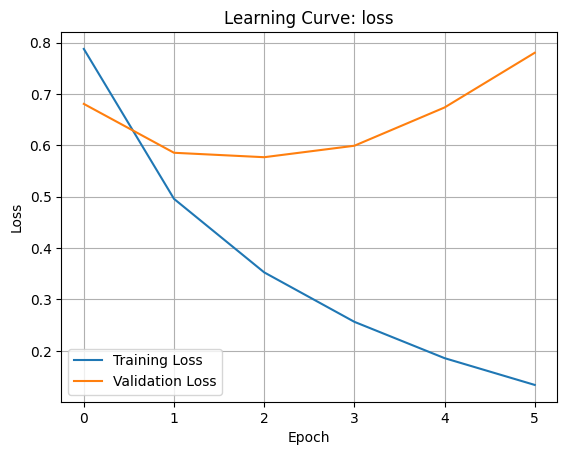

In [23]:
learning_curve(history, 'loss')

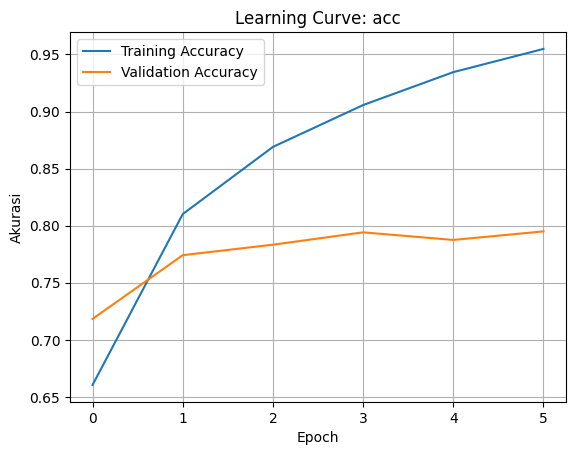

In [24]:
learning_curve(history, mode='acc')

In [25]:
modelFT.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

#evaluasi secara menyeluruh terhadap data multibahasa

In [26]:
test_dataloader = preprocess(test, False)

In [27]:
modelFT.eval()
all_preds = []
all_labels = []

with torch.no_grad():
  for batch in tqdm(test_dataloader, desc=f"[Testing]", leave=False):
    input_ids, attention_mask, labels = batch
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    labels = labels.to(device)

    outputs = modelFT(input_ids, attention_mask)
    _, predicted = torch.max(outputs.data, 1)

    all_preds.extend(predicted.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

In [28]:
print(f"Akurasi : {accuracy_score(all_labels, all_preds):.2f}")
print(f"Macro F1-Score : {f1_score(all_labels, all_preds,average='macro'):.2f}")

Akurasi : 0.81
Macro F1-Score : 0.80


#evaluasi untuk tiap bahasa

In [120]:
test = pd.read_csv('/content/drive/MyDrive/Final_Year/data_test.csv')

In [121]:
test.bahasa.unique()

array(['aceh', 'banjar', 'bali', 'bugis', 'minang', 'jawa', 'sunda',
       'indonesia', 'inggris', 'madura', 'ngaju', 'batak toba'],
      dtype=object)

In [122]:
test_bahasa = test[test.bahasa == 'batak toba']

In [123]:
test_bahasa["label"] = test_bahasa["label"].map(label_map)

/tmp/ipython-input-207329732.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_bahasa["label"] = test_bahasa["label"].map(label_map)


In [124]:
test_bahasa.head()

,text,label,bahasa
4400,"Jonok tu hotel hu marborngin, holan mardalan p...",2,batak toba
4401,"Ido toho, ibana manjaga kode",1,batak toba
4402,Kangkung nai boi ma alai gurampang saus padang...,0,batak toba
4403,Maringanan di braga cty walk na sada godung do...,2,batak toba
4404,Gianyar manjalo bantuan sosial (pangurupion) t...,1,batak toba


In [125]:
test_bahasa_dataloader = preprocess(test_bahasa, False)

In [126]:
modelFT.eval()
all_preds = []
all_labels = []

with torch.no_grad():
  for batch in tqdm(test_bahasa_dataloader, desc=f"[Testing]", leave=False):
    input_ids, attention_mask, labels = batch
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    labels = labels.to(device)

    outputs = modelFT(input_ids, attention_mask)
    _, predicted = torch.max(outputs.data, 1)

    all_preds.extend(predicted.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

##aceh

In [39]:
print(f"Akurasi : {accuracy_score(all_labels, all_preds):.2f}")
print(f"Macro F1-Score : {f1_score(all_labels, all_preds,average='macro'):.2f}")

Akurasi : 0.83
Macro F1-Score : 0.82


##banjar

In [47]:
print(f"Akurasi : {accuracy_score(all_labels, all_preds):.2f}")
print(f"Macro F1-Score : {f1_score(all_labels, all_preds,average='macro'):.2f}")

Akurasi : 0.84
Macro F1-Score : 0.83


##bali

In [55]:
print(f"Akurasi : {accuracy_score(all_labels, all_preds):.2f}")
print(f"Macro F1-Score : {f1_score(all_labels, all_preds,average='macro'):.2f}")

Akurasi : 0.79
Macro F1-Score : 0.79


##bugis

In [63]:
print(f"Akurasi : {accuracy_score(all_labels, all_preds):.2f}")
print(f"Macro F1-Score : {f1_score(all_labels, all_preds,average='macro'):.2f}")

Akurasi : 0.78
Macro F1-Score : 0.76


##minang

In [71]:
print(f"Akurasi : {accuracy_score(all_labels, all_preds):.2f}")
print(f"Macro F1-Score : {f1_score(all_labels, all_preds,average='macro'):.2f}")

Akurasi : 0.81
Macro F1-Score : 0.80


##jawa

In [79]:
print(f"Akurasi : {accuracy_score(all_labels, all_preds):.2f}")
print(f"Macro F1-Score : {f1_score(all_labels, all_preds,average='macro'):.2f}")

Akurasi : 0.83
Macro F1-Score : 0.83


##sunda

In [87]:
print(f"Akurasi : {accuracy_score(all_labels, all_preds):.2f}")
print(f"Macro F1-Score : {f1_score(all_labels, all_preds,average='macro'):.2f}")

Akurasi : 0.86
Macro F1-Score : 0.85


##indo

In [95]:
print(f"Akurasi : {accuracy_score(all_labels, all_preds):.2f}")
print(f"Macro F1-Score : {f1_score(all_labels, all_preds,average='macro'):.2f}")

Akurasi : 0.88
Macro F1-Score : 0.87


##ing

In [103]:
print(f"Akurasi : {accuracy_score(all_labels, all_preds):.2f}")
print(f"Macro F1-Score : {f1_score(all_labels, all_preds,average='macro'):.2f}")

Akurasi : 0.88
Macro F1-Score : 0.87


##madura

In [111]:
print(f"Akurasi : {accuracy_score(all_labels, all_preds):.2f}")
print(f"Macro F1-Score : {f1_score(all_labels, all_preds,average='macro'):.2f}")

Akurasi : 0.78
Macro F1-Score : 0.77


##ngaju

In [119]:
print(f"Akurasi : {accuracy_score(all_labels, all_preds):.2f}")
print(f"Macro F1-Score : {f1_score(all_labels, all_preds,average='macro'):.2f}")

Akurasi : 0.76
Macro F1-Score : 0.75


##batak toba

In [127]:
print(f"Akurasi : {accuracy_score(all_labels, all_preds):.2f}")
print(f"Macro F1-Score : {f1_score(all_labels, all_preds,average='macro'):.2f}")

Akurasi : 0.70
Macro F1-Score : 0.70
